# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import skimage.draw
from PIL import Image
import shutil

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model# as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# classes = ['dry_knot' , 'sound_knot']
# classes = ['dry_knot' , 'sound_knot','knot_hole', 'encased_knot', 'edge_knot', 'moustache_knot',
#            'leaf_knot', 'core_stripe','horn_knot','small_knot','UNKNOWN', 'resin', 'split',
#            'wane', 'bark_pocket', 'mould']
# classes = ['UNKNOWN', 'bark_pocket', 'core_stripe', 'decayed_knot', 'dry_knot',
#             'edge_knot', 'encased_knot', 'horn_knot', 'knot_hole', 'leaf_knot',
#             'mould', 'moustache_knot', 'resin', 'resin_pocket', 'small_knot',
#             'sound_knot', 'split', 'wane']
classes = ['decayed_knot', 'dry_knot', 'edge_knot', 'encased_knot',
           'horn_knot', 'leaf_knot', 'sound_knot', 'small_knot']

C:\Users\NCHU\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
class KnotsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = len(classes) + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 448

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5

config = KnotsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  448
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [448 448   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MI

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
# import json
# import skimage.draw
class KnotsDataset(utils.Dataset):

    def load_knots(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
#         self.add_class("knots", 1, "dry_knot")
#         self.add_class("knots", 2, "sound_knot")
        for i in range(len(classes)):
            self.add_class("knots", i+1, classes[i])
        

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)


        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions'].values()\
                       if list(r['region_attributes'].values())[0] in classes]
            name = [list(r['region_attributes'].values())[0] \
                    #判斷
#                     if list(r['region_attributes'].values())[0] in classes
#                     else 'UNKNOWN'
                    for r in a['regions'].values()\
                    if list(r['region_attributes'].values())[0] in classes]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "knots",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons, 
                name = name\
            )
            
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "knots":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        shapes = info['name']
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
            
        class_ids = np.array([self.class_names.index(s) for s in shapes])

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [5]:
# 自建立切割資料function
def cut_data(dataset_dir, keys, subset):
    '''提取keys內的資料，下載keys指定的圖片檔案與生成其標框之json檔
    dataset_dir: Root directory of the dataset.
    keys: list 原via_region_data.json檔內的希望體取的key
    subset: Subset to load: train or val
    '''
    assert subset in ["train", "val"]
    # 刪除與建立檔案
    if os.path.exists(os.path.join(dataset_dir, subset)):
        shutil.rmtree(os.path.join(dataset_dir, subset))
    os.mkdir(os.path.join(dataset_dir, subset))
    
    dic = {}
    for ele in keys:
        dic[ele] = annotations[ele]
        name = annotations[ele]['filename']
        image = Image.open(os.path.join(dataset_dir, "all\\%s"%name))
        image.save(os.path.join(dataset_dir, subset, name))

    # 存json檔
    with open(os.path.join(dataset_dir, "%s\\via_region_data.json")%subset, 'w') as fp:
        json.dump(dic, fp)

In [6]:
knots_dir = os.path.join(ROOT_DIR, "datasets\\knots")
knots_dir

'C:\\Users\\NCHU\\Python\\paper\\Mask_RCNN-ver(weight)\\datasets\\knots'

#  分割資料

In [7]:
# #生成train的資料
# annotations = json.load(open(os.path.join(knots_dir, "all\\via_region_data.json")))
# keys_train = np.random.choice(list(annotations.keys()), int(len(annotations) * 0.8), replace=False)
# # keys_train = ['st1100.jpg17302', 'st1101.jpg17199']
# cut_data(knots_dir, keys_train, "train")

# #生成val的資料
# keys_val = [key for key in list(annotations.keys()) if key not in keys_train]
# cut_data(knots_dir, keys_val, "val")

# print("train:", len(keys_train), "val:", len(keys_val))

In [7]:
dataset_train = KnotsDataset()
dataset_train.load_knots(knots_dir, "train")
# Must call before using the dataset
dataset_train.prepare()

dataset_val = KnotsDataset()
dataset_val.load_knots(knots_dir, "val")
dataset_val.prepare()

In [8]:
for ele in os.walk(os.path.join(knots_dir, "train")):
    folderCount = len(ele[2]) - 1
print("Image Count: {}({})".format(folderCount, len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 550(471)
Class Count: 9
  0. BG                                                
  1. decayed_knot                                      
  2. dry_knot                                          
  3. edge_knot                                         
  4. encased_knot                                      
  5. horn_knot                                         
  6. leaf_knot                                         
  7. sound_knot                                        
  8. small_knot                                        


## Ceate Model

In [9]:
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
MODEL_DIR

'C:\\Users\\NCHU\\Python\\paper\\Mask_RCNN-ver(weight)\\logs'

In [12]:
# Create model in training mode
model = mrcnn.model.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [13]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [12]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\NCHU\Python\paper\Mask_RCNN-ver(weight)\logs\shapes20180613T2110\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (

C:\Users\NCHU\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
100/100 [==============================] - 281s 3s/step - loss: 2.6655 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 1.1740 - mrcnn_class_loss: 0.2120 - mrcnn_bbox_loss: 0.6457 - mrcnn_mask_loss: 0.5947 - val_loss: 1.7878 - val_rpn_class_loss: 0.0248 - val_rpn_bbox_loss: 0.7083 - val_mrcnn_class_loss: 0.1180 - val_mrcnn_bbox_loss: 0.4666 - val_mrcnn_mask_loss: 0.4702
Epoch 2/10
100/100 [==============================] - 250s 3s/step - loss: 1.5819 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.6941 - mrcnn_class_loss: 0.1183 - mrcnn_bbox_loss: 0.3444 - mrcnn_mask_loss: 0.4108 - val_loss: 1.6606 - val_rpn_class_loss: 0.0120 - val_rpn_bbox_loss: 0.7330 - val_mrcnn_class_loss: 0.1539 - val_mrcnn_bbox_loss: 0.4153 - val_mrcnn_mask_loss: 0.3464
Epoch 3/10
100/100 [==============================] - 251s 3s/step - loss: 1.3263 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.5704 - mrcnn_class_loss: 0.1387 - mrcnn_bbox_loss: 0.2652 - mrcnn_mask_loss: 0.3404 - val_loss: 1.5861 - val_rpn_class_l

In [17]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=5, 
            layers="all")

In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

# 循環寫weight

In [10]:
def write_w1_py(i, j):
    '''model.py 中i替換掉j(for w1)'''
    modelpy_path = os.path.join(ROOT_DIR, "mrcnn", "model.py")
#     file = 
    inputpy = ""
    for line in open(modelpy_path,"r"):
        a = line.split('%s * loss  #@change@#'%str(j))
        
        if(len(a)>1):
            print("Success Change w1 ", i,"to", j)
            a[0] += '%s * loss  #@change@#\n'%str(i)
        inputpy += a[0]
#     file = open(modelpy_path, "w") 
#     file.write(inputpy) 
#     file.close()
    write2model(inputpy)
#     return(inputpy)

In [11]:
def write_w2_py(i, j):
    '''model.py 中i替換掉j(for w2)  w1=1'''
    write_w1_py(1, 50)
    modelpy_path = os.path.join(ROOT_DIR, "mrcnn", "model.py")
#     file = open(modelpy_path,"r")
    inputpy = ""
    for line in open(modelpy_path,"r"):
        a = line.split('%s * loss  #@@change@w2#'%str(j))
        if(len(a)>1):
            print("Success Change w2 ", i,"to", j)
            a[0] += '%s * loss  #@@change@w2#\n'%str(i)
        inputpy += a[0]
#     file = open(modelpy_path, "w") 
#     file.write(inputpy) 
#     file.close()
    write2model(inputpy)
#     return(inputpy)

In [12]:
def write2model(inputpy):
    modelpy_path = os.path.join(ROOT_DIR, "mrcnn", "model.py")
    file = open(modelpy_path, "w") 
    file.write(inputpy) 
    file.close()

In [14]:
#重置
# write_w1_py(1, 50)
write_w2_py(1, 50)

In [14]:
# config.gpu_options.allow_growth

In [ ]:
from importlib import reload
import time
# import os
# import sys

# ROOT_DIR = os.path.abspath("../../")
# sys.path.append(ROOT_DIR)
# import mrcnn.model
st = time.time()
y = 2
for x in [5]:
    write_w2_py(x, y)
    y = x
    
    j = 1
    for i in [1, 2, 5, 10, 20, 50]:
        print("rpn_class_loss * %s, mrcnn_class_loss * %s"%(i,x))
        write_w1_py(i, j)
        j = i
        time.sleep(1)
        
        reload(mrcnn.model)
        model = mrcnn.model.MaskRCNN(mode="training", config=config,
                                     model_dir=MODEL_DIR)
        model.load_weights(COCO_MODEL_PATH, by_name=True,
                           exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                    "mrcnn_bbox", "mrcnn_mask"])
        model.train(dataset_train, dataset_val, 
                    learning_rate=config.LEARNING_RATE, 
                    epochs=10, 
                    layers='heads')
#         del model
en = time.time()
print(en-st)

Success Change w1  1 to 50
Success Change w2  5 to 2
rpn_class_loss * 1, mrcnn_class_loss * 5
Success Change w1  1 to 1

Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\NCHU\Python\paper\Mask_RCNN-ver(weight)\logs\shapes20180617T2239\mask_rcnn_shapes_{epoch:03d}-{val_loss:.4f}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_b

C:\Users\NCHU\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
 59/100 [================>.............] - ETA: 1:42 - loss: 3.7812 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 1.4754 - mrcnn_class_loss: 0.6063 - mrcnn_bbox_loss: 0.9300 - mrcnn_mask_loss: 0.7141

In [17]:
import gc
gc.collect()
memory usage dedicate

145320

In [18]:
import gc
del model
gc.collect()

0

## Detection

In [13]:
config.NAME.lower()

'shapes'

In [46]:
model.find_last()[1]

'C:\\Users\\NCHU\\Python\\paper\\Mask_RCNN-master\\logs\\shapes20180528T1530\\mask_rcnn_shapes_0005.h5'

In [17]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# WEIGHTS_DIR = model.find_last()[1]#下載最後位置
WEIGHTS_DIR = os.path.join(ROOT_DIR, "weigh\\1 2 2 005-1.5473.h5") #下載指定位置

In [18]:
# InferenceConfig
class InferenceConfig(KnotsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
inference_config = InferenceConfig()

# load model
model = mrcnn.model.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=WEIGHTS_DIR)

# Load trained weights (fill in path to trained weights here)
assert WEIGHTS_DIR != "", "Provide path to trained weights"
print("Loading weights from ", WEIGHTS_DIR)
model.load_weights(WEIGHTS_DIR, by_name=True)

Loading weights from  C:\Users\NCHU\Python\paper\Mask_RCNN-ver(weight)\weigh\1 2 2 005-1.5473.h5


In [49]:
for image_id in range(len(dataset_val.image_ids)):
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    
    
    results = model.detect([original_image], verbose=0)
    r = results[0]
    
    print(image_id, gt_class_id, r['class_ids'])

0 [2 8] [2 8 8]
1 [7 2 4 4] [7 2 7]
2 [8] [3 8]
3 [7 2 2 2 2 4] [7 2 8 3]
4 [2] [2]
5 [2] [2 7]
6 [] []
7 [7 3] [7 7]
8 [7] [7 8]
9 [2] []
10 [2 8 8] [2 8 2]
11 [8 8 8] [2 8]
12 [2 2 2] [2 4 4]
13 [7] [7 2]
14 [2] [2]
15 [6 7 8] [8]
16 [7 8] [7 8]
17 [2 5 8 2 2 6] [7 8 2 8 3 7]
18 [4] [7 7 8 3 7]
19 [2] [7 8]
20 [8] [8]
21 [8 8] []
22 [] [2]
23 [2] [2]
24 [] []
25 [5] []
26 [8 8 7] [8]
27 [7] [7 8]
28 [8] []
29 [8] [8]
30 [2] [7]
31 [2] [2]
32 [4 4] [7 4]
33 [4] [8 3 3 3 8]


original_image           shape: (448, 448, 3)         min:    0.00000  max:  252.00000  uint8
image_meta               shape: (21,)                 min:    0.00000  max:  512.00000  float64
gt_class_id              shape: (3,)                  min:    6.00000  max:    8.00000  int32
gt_bbox                  shape: (3, 4)                min:   50.00000  max:  287.00000  int32
gt_mask                  shape: (448, 448, 3)         min:    0.00000  max:    1.00000  bool


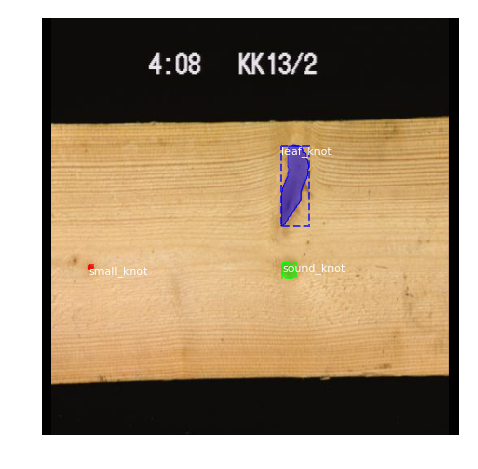

In [50]:
# Test on a random image
# image_id = random.choice(dataset_val.image_ids)
image_id = 15
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

try :
    log("original_image", original_image)
    log("image_meta", image_meta)
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)

finally:
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (448, 448, 3)         min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 448, 448, 3)      min: -123.70000  max:  140.10000  float64
image_metas              shape: (1, 21)               min:    0.00000  max:  448.00000  float64
anchors                  shape: (1, 50127, 4)         min:   -0.20248  max:    1.05931  float32


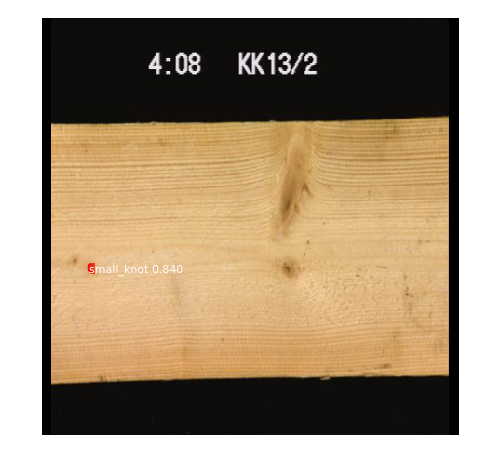

In [51]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [220]:
r

{'class_ids': array([], dtype=int32),
 'masks': array([], shape=(28, 28, 0), dtype=float64),
 'rois': array([], shape=(0, 4), dtype=int32),
 'scores': array([], dtype=float32)}

In [218]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

ValueError: cannot reshape array of size 0 into shape (0)

In [9]:
def model_load_overlaps(image_id):
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
        
    results = model.detect([original_image], verbose=0)
    r = results[0]
    if len(r['class_ids']) == 0 or len(gt_class_id) == 0:
        overlaps = 0
    else:
        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    return(gt_class_id, r, overlaps)

In [10]:
# 建立全為0的confusion_matrix
n = len(dataset_train.class_names)
confusion_matrix = np.zeros([n, n], dtype=np.uint8)
# confusion_matrix, dataset_train.class_names

In [11]:
#標記confusion_matrix
for image_id in range(len(dataset_val.image_ids)):
    print(image_id)
    gt_class_id, r, overlaps = model_load_overlaps(image_id)
    if len(gt_class_id) < 1: # 處理原圖無標記圖片
        for lis in  r['class_ids']:
#             print(lis, 0)
            confusion_matrix[lis, 0] += 1
    elif len(r['class_ids']) < 1:
        for lis in gt_class_id:
            confusion_matrix[0, lis] += 1
#             print(confusion_matrix)
    else:
        i = 0
        for lis in overlaps:
            if np.max(lis) > 0: # 正常
#                 print(r['class_ids'][i], gt_class_id[np.argmax(lis)])
                confusion_matrix[r['class_ids'][i], gt_class_id[np.argmax(lis)]] += 1

            elif np.max(lis) == 0: # 背景標knots
#                 print(r['class_ids'][i], 0)
                confusion_matrix[r['class_ids'][i], 0] += 1
            i+=1

        if(np.argmax(overlaps.shape) == 1): # knots標背景
            #找出為0的classid
            a = [gt_class_id[ele[0]] for ele in enumerate(overlaps.T) if sum(ele[1])==0]
            for i in a:
                confusion_matrix[0, i] += 1
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71


In [197]:
confusion_matrix

array([[0, 0, 4, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 1, 0, 0, 0, 0, 3]], dtype=uint8)

In [12]:
confusion_matrix

array([[ 0,  0,  1,  5,  0,  3,  2,  2, 12],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 6,  1, 29,  3,  4,  0,  0,  3,  4],
       [17,  0,  0,  4,  0,  0,  0,  0,  0],
       [ 1,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 2,  0,  0,  0,  0,  1,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 3,  0,  8,  1,  5,  0,  1, 36,  2],
       [36,  0,  3,  0,  0,  0,  0,  1, 27]], dtype=uint8)

In [13]:
import pandas as pd
pd.DataFrame(confusion_matrix, columns=dataset_train.class_names, 
            index=dataset_train.class_names)

,BG,decayed_knot,dry_knot,edge_knot,encased_knot,horn_knot,leaf_knot,sound_knot,small_knot
BG,0,0,1,5,0,3,2,2,12
decayed_knot,0,0,0,0,0,0,0,0,0
dry_knot,6,1,29,3,4,0,0,3,4
edge_knot,17,0,0,4,0,0,0,0,0
encased_knot,1,0,1,0,0,0,0,0,0
horn_knot,2,0,0,0,0,1,1,0,0
leaf_knot,0,0,0,0,0,0,0,0,0
sound_knot,3,0,8,1,5,0,1,36,2
small_knot,36,0,3,0,0,0,0,1,27


In [15]:
sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

0.4311111111111111

In [17]:
sum(np.diag(confusion_matrix[1:,1:])) / np.sum(confusion_matrix[1:,1:])

0.7185185185185186

In [14]:
a = sum(confusion_matrix[:,1:].T)
1-a[0]/sum(a)

0.84375

In [62]:
confusion_matrix / sum(confusion_matrix)

C:\Users\NCHU\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[0.        ,        nan, 0.15      , 0.        , 0.25      ,
        1.        , 0.33333333, 0.2       , 0.33333333],
       [0.        ,        nan, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.11111111,        nan, 0.5       , 0.        , 0.125     ,
        0.        , 0.        , 0.        , 0.13333333],
       [0.38888889,        nan, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        ,        nan, 0.1       , 0.        , 0.125     ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        ,        nan, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        ,        nan, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.11111111,        nan, 0.15      , 1.        , 0.375     ,
        0.        , 0.66666667, 0.7       , 0.        ],


In [63]:
confusion_matrix_round = np.round(confusion_matrix / sum(confusion_matrix), 3)
pd.DataFrame(confusion_matrix_round * 100,
             columns=dataset_train.class_names,
             index=dataset_train.class_names)

C:\Users\NCHU\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


,BG,decayed_knot,dry_knot,edge_knot,encased_knot,horn_knot,leaf_knot,sound_knot,small_knot
BG,0.0,NaN,15.0,0.0,25.0,100.0,33.3,20.0,33.3
decayed_knot,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dry_knot,11.1,NaN,50.0,0.0,12.5,0.0,0.0,0.0,13.3
edge_knot,38.9,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
encased_knot,0.0,NaN,10.0,0.0,12.5,0.0,0.0,0.0,0.0
horn_knot,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
leaf_knot,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sound_knot,11.1,NaN,15.0,100.0,37.5,0.0,66.7,70.0,0.0
small_knot,38.9,NaN,10.0,0.0,12.5,0.0,0.0,10.0,53.3


In [60]:
sum(np.diag(confusion_matrix_round))+sum(confusion_matrix_round.T[0])

0.5780000000000001

In [64]:
confusion_matrix2 = confusion_matrix[1:,1:]
pd.DataFrame(confusion_matrix2, columns=dataset_train.class_names[1:], 
            index=dataset_train.class_names[1:])

,decayed_knot,dry_knot,edge_knot,encased_knot,horn_knot,leaf_knot,sound_knot,small_knot
decayed_knot,0,0,0,0,0,0,0,0
dry_knot,0,10,0,1,0,0,0,2
edge_knot,0,0,0,0,0,0,0,0
encased_knot,0,2,0,1,0,0,0,0
horn_knot,0,0,0,0,0,0,0,0
leaf_knot,0,0,0,0,0,0,0,0
sound_knot,0,3,1,3,0,2,7,0
small_knot,0,2,0,1,0,0,1,8


In [66]:
confusion_matrix_round2 = np.round(confusion_matrix2 / sum(confusion_matrix2), 3)
pd.DataFrame(confusion_matrix_round2 * 100,
             columns=dataset_train.class_names[1:],
             index=dataset_train.class_names[1:])

C:\Users\NCHU\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


,decayed_knot,dry_knot,edge_knot,encased_knot,horn_knot,leaf_knot,sound_knot,small_knot
decayed_knot,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0
dry_knot,NaN,58.8,0.0,16.7,NaN,0.0,0.0,20.0
edge_knot,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0
encased_knot,NaN,11.8,0.0,16.7,NaN,0.0,0.0,0.0
horn_knot,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0
leaf_knot,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0
sound_knot,NaN,17.6,100.0,50.0,NaN,100.0,87.5,0.0
small_knot,NaN,11.8,0.0,16.7,NaN,0.0,12.5,80.0


In [262]:
sum(np.diag(confusion_matrix_round2))

0.6859999999999999

In [150]:
import pandas as pd
pd.DataFrame(overlaps,
             columns=[dataset_train.class_names[s] for s in gt_class_id],
             index=[dataset_train.class_names[s] for s in r['class_ids']])

,dry_knot,dry_knot,dry_knot
dry_knot,0.8125,0.0,0.000000
dry_knot,0.0000,0.0,0.754098


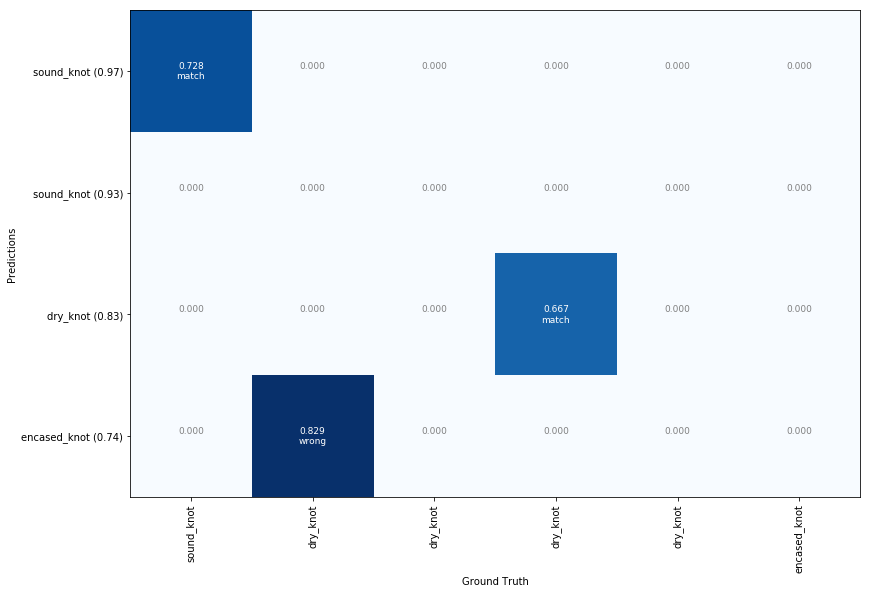

In [137]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset_val.class_names)

In [124]:
dataset_val.class_names

['BG',
 'decayed_knot',
 'dry_knot',
 'edge_knot',
 'encased_knot',
 'horn_knot',
 'leaf_knot',
 'sound_knot']

In [105]:
image_id = 10
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
# original_image, gt_bbox, gt_mask, gt_class_id,
# original_image, r['rois'], r['masks'], r['class_ids']
results = model.detect([original_image], verbose=1)
r = results[0]
r['class_ids'], gt_class_id, gt_bbox, r['rois'], sum(sum(gt_mask)), sum(sum(r['masks']))

Processing 1 images
image                    shape: (448, 448, 3)         min:    0.00000  max:  249.00000  uint8
molded_images            shape: (1, 448, 448, 3)      min: -123.70000  max:  144.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max:  448.00000  float64
anchors                  shape: (1, 50127, 4)         min:   -0.20248  max:    1.05931  float32


(array([2, 2, 7]),
 array([2]),
 array([[332, 224, 357, 237]]),
 array([[335, 223, 354, 236],
        [325, 334, 335, 342],
        [258,  80, 286, 102]]),
 array([224]),
 array([194,  55, 428]))

## Evaluation

In [66]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
image_ids = [3,4]
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    print(gt_class_id,"----------------")
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    print(AP, precisions, recalls, overlaps)
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

[1 1] ----------------
1.0 [1. 1. 1. 0.] [0.  0.5 1.  1. ] [[0.         0.82733816]
 [0.880597   0.        ]]
[1 1 1 1 2] ----------------
0.800000011920929 [1. 1. 1. 1. 1. 0.] [0.         0.2        0.40000001 0.60000002 0.80000001 1.        ] [[0.         0.         0.         0.         0.86223567]
 [0.         0.         0.         0.8288288  0.        ]
 [0.9280262  0.         0.         0.         0.        ]
 [0.         0.8210526  0.         0.         0.        ]]
mAP:  0.9000000059604645


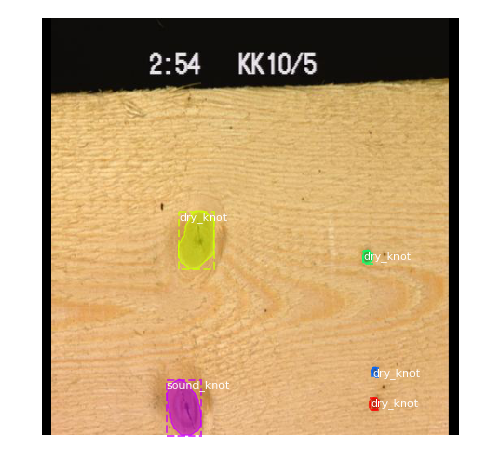

Processing 1 images
image                    shape: (448, 448, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 448, 448, 3)      min: -123.70000  max:  141.10000  float64
image_metas              shape: (1, 29)               min:    0.00000  max:  448.00000  float64
anchors                  shape: (1, 50127, 4)         min:   -0.20248  max:    1.05931  float32


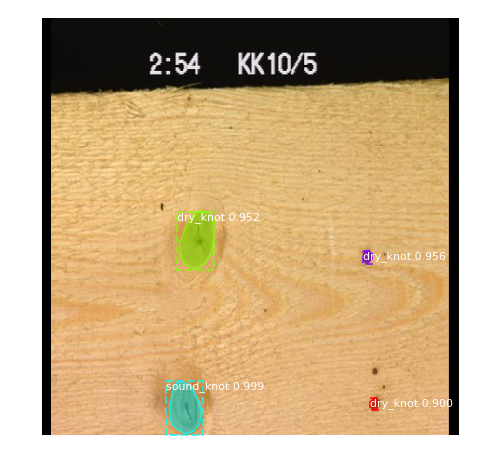

In [70]:
image_id = 4
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)


visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [73]:
print(gt_class_id, r['class_ids'])

[ 1  1  1 12] [ 1  1  1 12]


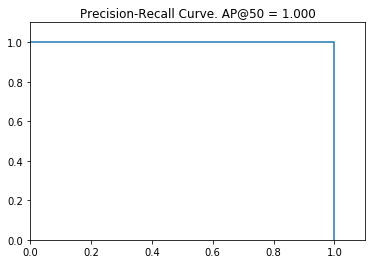

In [106]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

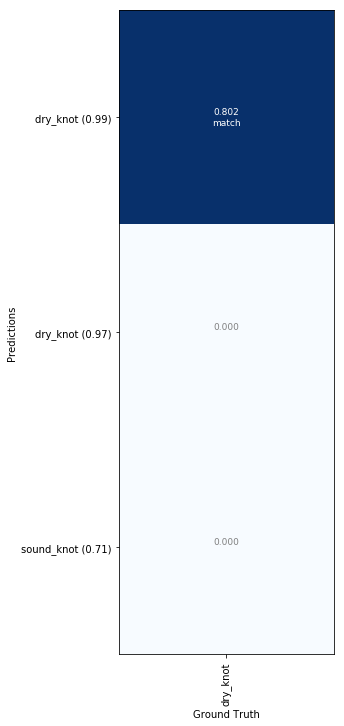

In [108]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset_val.class_names)

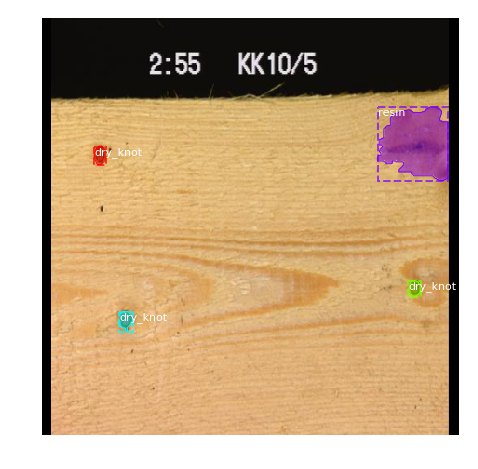

Processing 1 images
image                    shape: (448, 448, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 448, 448, 3)      min: -123.70000  max:  140.10000  float64
image_metas              shape: (1, 29)               min:    0.00000  max:  448.00000  float64
anchors                  shape: (1, 50127, 4)         min:   -0.20248  max:    1.05931  float32


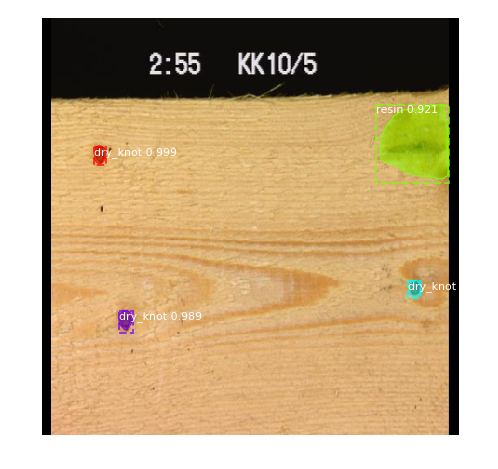

In [71]:
image_id = 5
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)


visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())